In [1]:
from math import pi, cos
path               = "/home/gonzalo/data/CC/Cf/sim/"
solid_angle        = (1 - cos(10*pi/180)) / 2
nevt               = 1e6
fission_fraction   = 0.03
gammas_per_decay   = 8.3
neutrons_per_decay = 3.7

In [14]:
density = dict( lif = 2.635
              , water = 1.000
              )

volume = dict( lif = 0.5**3
             , water = 0.5**3
             )

mass = {m: density[m] * volume[m] for m in set(list(density)+list(volume))}

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from CCplot import figure
from CCplot import subplot
from CCplot import auto_plot_style

from CCplot import change_jupyter_width

In [4]:
%matplotlib inline

%load_ext skip_cell

auto_plot_style()

exec(change_jupyter_width(90))

In [15]:
def load(filename, table="/MC/hits"):
    filename = os.path.join(path, filename)
    df = pd.read_hdf(filename, table)
    columns_to_drop = [c for c in df.columns if "momentum" in c]
    return df.drop(columns=columns_to_drop) if columns_to_drop else df

def dose(df, particles_per_decay):
    return df.energy.sum() * 1e6 * 1.602e-19 / nevt / particles_per_decay / fission_fraction / solid_angle / mass["lif"]

In [16]:
thicknesses  = list(range(7, 15))
gammas       = [load(f"lif_g_{t}cm.cc"  ) for t in thicknesses]
neutrons     = [load(f"lif_n_{t}cm.cc") for t in thicknesses]
gamma_dose   = np.asarray([dose(df,   gammas_per_decay) for df in gammas])
neutron_dose = np.asarray([dose(df, neutrons_per_decay) for df in neutrons])

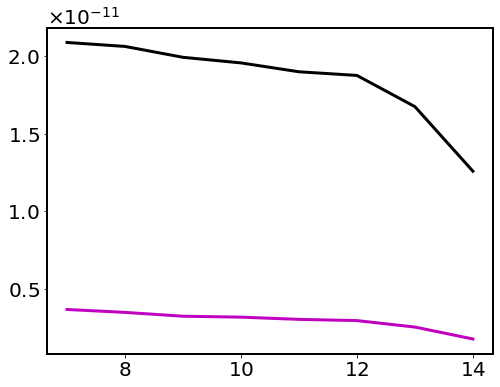

In [22]:
plt.plot(thicknesses, neutron_dose)
plt.plot(thicknesses, gamma_dose  );

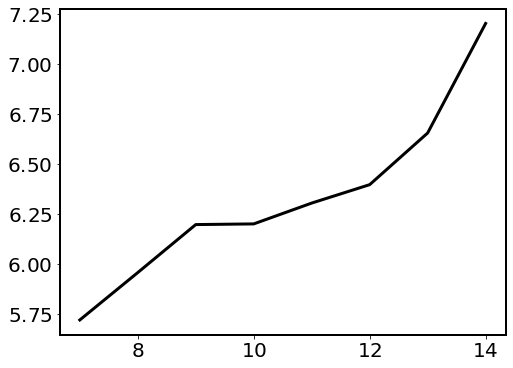

In [23]:
plt.plot(thicknesses, neutron_dose/gamma_dose);

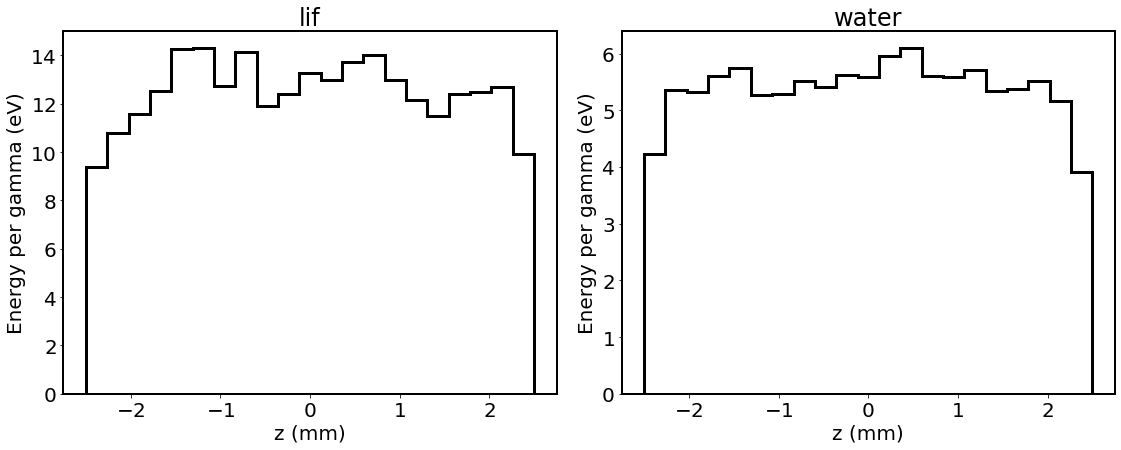

In [12]:
figure(5)
for i, c in enumerate(crystals, start=1):
    subplot(5, i)
    plt.hist(dfs[c].z, 21, weights=dfs[c].energy / nevt * 1e6, histtype="step")
    plt.xlabel("z (mm)")
    plt.ylabel("Energy per gamma (eV)")
    plt.title(c)

plt.tight_layout()

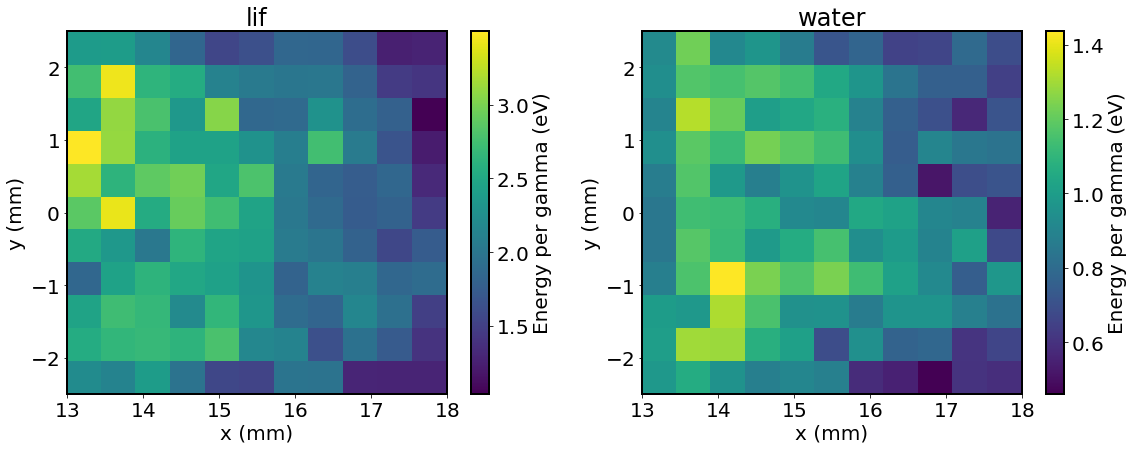

In [13]:

figure(5)
for i, c in enumerate(crystals, start=1):
    subplot(5, i)
    plt.hist2d(dfs[c].x, dfs[c].y, (11, 11), weights=dfs[c].energy / nevt * 1e6)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.title(c)
    plt.colorbar().set_label("Energy per gamma (eV)")
plt.tight_layout()

In [14]:
summary = []
for crystal, df in dfs.items():
    mass_kg        = density[crystal] * volume[crystal] / 1e3
    deposited_e_J  = df.energy.sum() / nevt * 1e6 * 1.602e-19 
    dose_per_gamma = deposited_e_J / mass_kg
    
    summary.append(pd.DataFrame(dict( crystal        =         crystal
                                    , density        = density[crystal]
                                    , volume         = volume [crystal]
                                    , mass           = mass_kg
                                    , E_per_gamma    = deposited_e_J
                                    , dose_per_gamma = dose_per_gamma
                                    )
                               , index = [0]))

summary = pd.concat(summary, ignore_index=True, sort=False)

In [15]:
summary = summary.assign(total_dose = activity * n_gammas_per_event * t * summary.dose_per_gamma)
summary

crystal  density  volume      mass   E_per_gamma  dose_per_gamma  total_dose
0     lif    2.635   0.125  0.000329  4.202217e-17    1.275815e-13    1.223558
1   water    1.000   0.125  0.000125  1.812950e-17    1.450360e-13    1.390954

In [16]:
1.390954/1.223558

1.1368108418235998